# Visual

In [12]:
from io import StringIO
import pandas as pd
import numpy as np
import random
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.constants import physical_constants, milli

import sys
sys.path.append("..")

import src.core.config as cfg
from src.elegant import utils, eleget, eleput

pd.options.plotting.backend = "plotly"

In [13]:
utils._run_elegant_process()

In [14]:
ELEMENT_X_POSITION_ERROR = 1*milli
ELEMENT_Y_POSITION_ERROR = 1*milli
ELEMENT_Z_POSITION_ERROR = 1*milli
ELEMENT_ROTATION_ERROR = 1*milli
ELEMENT_FIELD_ERROR = 1*milli

parameters_beamline_data = utils.sdds_to_df(file=cfg.ELEGANT_PARAMETERS_DATA_FILE, columns=cfg.ELEGANT_PARAMETERS_DATA_COLUMNS)
elements = set(parameters_beamline_data[parameters_beamline_data["ElementType"] == "QUAD"]["ElementName"])

for element in elements:
    utils.update_parameter(element, "DX", random.gauss(0, ELEMENT_X_POSITION_ERROR), file=cfg.ELEGANT_SIMULATION_CONFIG_PARAMETERS_FILE)
    utils.update_parameter(element, "DY", random.gauss(0, ELEMENT_Y_POSITION_ERROR), file=cfg.ELEGANT_SIMULATION_CONFIG_PARAMETERS_FILE)
    utils.update_parameter(element, "DZ", random.gauss(0, ELEMENT_Z_POSITION_ERROR), file=cfg.ELEGANT_SIMULATION_CONFIG_PARAMETERS_FILE)
    utils.update_parameter(element, "TILT", random.gauss(0, ELEMENT_ROTATION_ERROR), file=cfg.ELEGANT_SIMULATION_CONFIG_PARAMETERS_FILE)
    utils.update_parameter(element, "FSE", random.gauss(0, ELEMENT_FIELD_ERROR), file=cfg.ELEGANT_SIMULATION_CONFIG_PARAMETERS_FILE)

/home/fedorov/Work/skif-utils/notebooks/../src/elegant/utils.py:244: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [15]:
utils._run_elegant_process()

In [16]:
beamline_data = utils.sdds_to_df(file=cfg.ELEGANT_BEAMLINE_DATA_FILE, columns=cfg.ELEGANT_BEAMLINE_DATA_COLUMNS)
twiss_data = utils.sdds_to_df(file=cfg.ELEGANT_TWISS_DATA_FILE, columns=cfg.ELEGANT_TWISS_DATA_COLUMNS)
centroid_data = utils.sdds_to_df(file=cfg.ELEGANT_CENTROID_DATA_FILE, columns=cfg.ELEGANT_CENTROID_DATA_COLUMNS)

In [17]:
twiss_data["p"] = twiss_data["pCentral0"]*physical_constants["electron mass energy equivalent in MeV"][0]
centroid_data["p"] = centroid_data["pCentral"]*physical_constants["electron mass energy equivalent in MeV"][0]

e_nx = 10.2 # normalized emittance [mm*mrad]
e_ny = e_nx

twiss_data['emitx'] = e_nx * milli * milli / (twiss_data['p']/physical_constants["electron mass energy equivalent in MeV"][0]) # geometric emittance [m]
twiss_data['emity'] = e_ny * milli * milli / (twiss_data['p']/physical_constants["electron mass energy equivalent in MeV"][0]) # geometric emittance [m]
twiss_data['dp/p'] = 0

twiss_data['sigmax'] = np.sqrt(twiss_data['betax']*twiss_data['emitx'] + twiss_data['etax']*twiss_data['etax']*twiss_data['dp/p']*twiss_data['dp/p']) # mm
twiss_data['sigmay'] = np.sqrt(twiss_data['betay']*twiss_data['emity'] + twiss_data['etay']*twiss_data['etay']*twiss_data['dp/p']*twiss_data['dp/p']) # mm

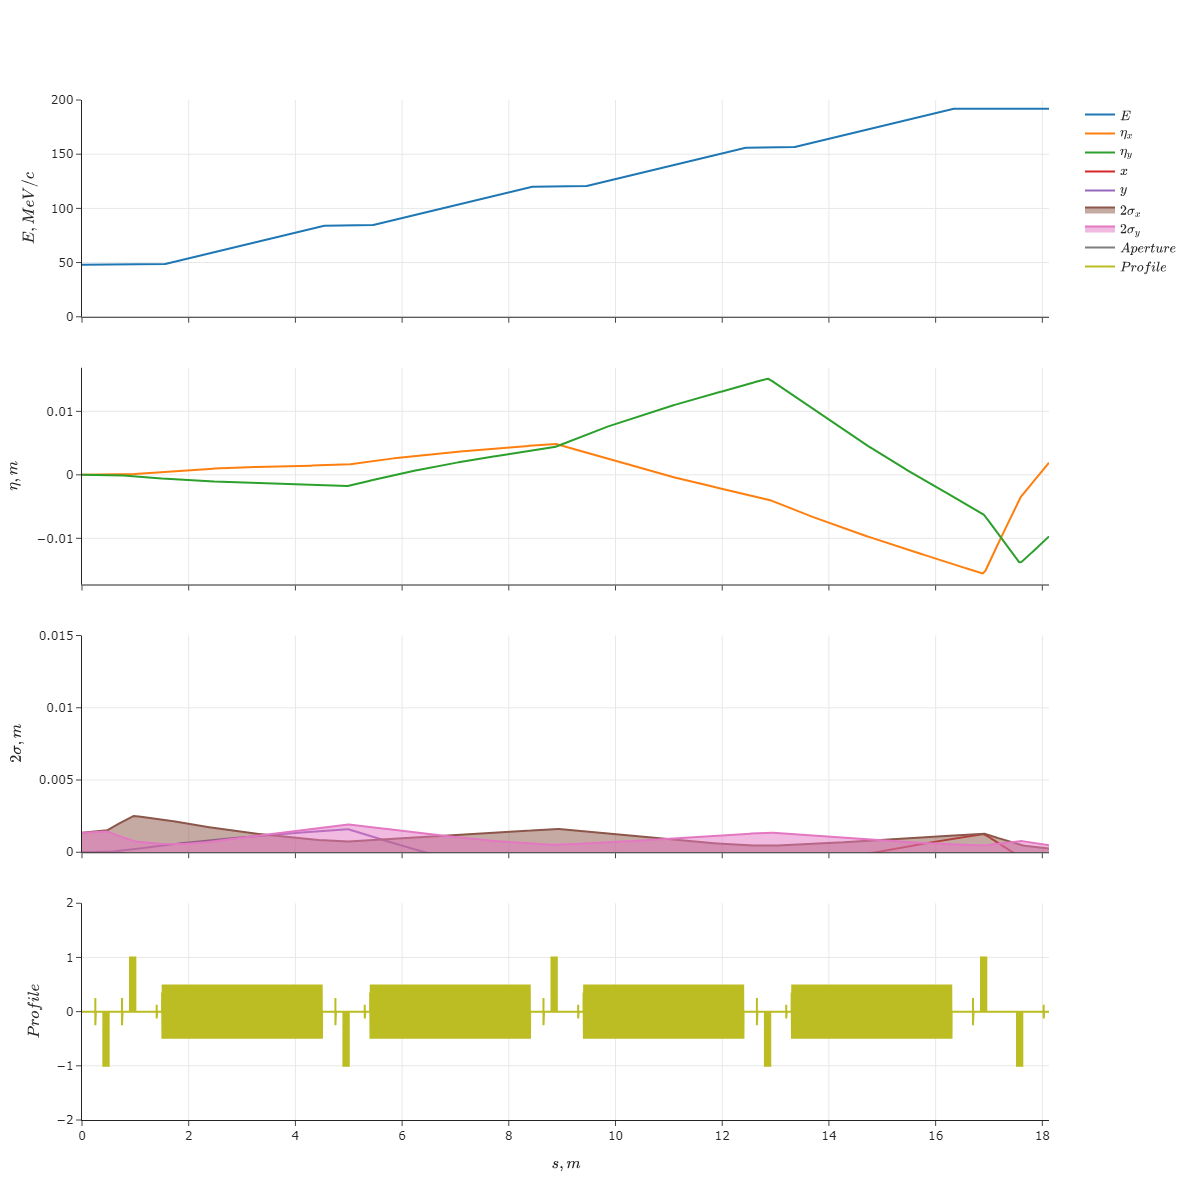

In [18]:
fig = make_subplots(
    rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.05,
)

fig.add_trace(
    go.Scatter(x=twiss_data["s"], y=twiss_data["p"], name=r'$E$',
               hovertemplate=(
                   "<b>s</b>: %{x:.2f} m<br>"
                   "<b>Energy</b>: %{y:.2f} MeV/c<br>"
                    "<extra></extra>"
               )
    ),
    row=1, col=1,
)

fig.add_trace(
    go.Scatter(x=twiss_data["s"], y=twiss_data["etax"], name=r'$\eta_x$',
               hovertemplate=(
                   "<b>s</b>: %{x:.2f} m<br>"
                   "<b>Dispersion x</b>: %{y:.2f} m<br>"
                    "<extra></extra>"
               )
    ),
    row=2, col=1,
)

fig.add_trace(
    go.Scatter(x=twiss_data["s"], y=twiss_data["etay"], name=r'$\eta_y$',
               hovertemplate=(
                   "<b>s</b>: %{x:.2f} m<br>"
                   "<b>Dispersion y</b>: %{y:.2f} m<br>"
                    "<extra></extra>"
               )
    ),
    row=2, col=1,
)

fig.add_trace(
    go.Scatter(x=centroid_data["s"], y=centroid_data["Cx"], name=r'$x$',
               hovertemplate=(
                   "<b>s</b>: %{x:.2f} m<br>"
                   "<b>Centroid x</b>: %{y:.2f} m<br>"
                    "<extra></extra>"
               )
    ),
    row=3, col=1,
)

fig.add_trace(
    go.Scatter(x=centroid_data["s"], y=centroid_data["Cy"], name=r'$y$',
               hovertemplate=(
                   "<b>s</b>: %{x:.2f} m<br>"
                   "<b>Centroid y</b>: %{y:.2f} m<br>"
                    "<extra></extra>"
               )
    ),
    row=3, col=1,
)

fig.add_trace(
    go.Scatter(x=twiss_data["s"], y=2*twiss_data["sigmax"], fill="tozeroy", name=r'$2\sigma_x$', 
               hovertemplate=(
                   "<b>s</b>: %{x:.2f} m<br>"
                   "<b>Envelope x</b>: %{y:.2f} m<br>"
                    "<extra></extra>"
               )
    ),
    row=3, col=1,
)

fig.add_trace(
    go.Scatter(x=twiss_data["s"], y=2*twiss_data["sigmay"], fill="tozeroy", name=r'$2\sigma_y$',
               hovertemplate=(
                   "<b>s</b>: %{x:.2f} m<br>"
                   "<b>Envelope y</b>: %{y:.2f} m<br>"
                    "<extra></extra>"
               )
    ),
    row=3, col=1,
)

fig.add_trace(
    go.Scatter(x=twiss_data["s"], y=twiss_data["xAperture"], name=r"$Aperture$",
               hovertemplate=(
                   "<b>s</b>: %{x:.2f} m<br>"
                   "<b>Aperture</b>: %{y:.2f} m<br>"
                    "<extra></extra>"
               )
    ),
    row=3, col=1,
)

fig.add_trace(
    go.Scatter(x=beamline_data["s"], y=beamline_data["Profile"], text=beamline_data["ElementName"], name=r"$Profile$",
               hovertemplate=(
                   "<b>s</b>: %{x:.2f} m<br>"
                   "<b>Name</b>: %{text}<br>"
                    "<extra></extra>"
               )
    ),
    row=4, col=1
)

fig.update_layout(
    height=1200, template="simple_white", showlegend=True,
)

fig.update_xaxes(showgrid=True, row=1, col=1)
fig.update_yaxes(title_text=r"$E, MeV/c$", range=(0, 200), showgrid=True, row=1, col=1)

fig.update_xaxes(showgrid=True, row=2, col=1)
fig.update_yaxes(title_text=r"$\eta, m$", showgrid=True, row=2, col=1)

fig.update_xaxes(showgrid=True, row=3, col=1)
fig.update_yaxes(title_text=r"$2\sigma, m$", range=(0, 15e-3), showgrid=True, row=3, col=1)

fig.update_xaxes(title_text=r"$s, m$", showgrid=True, row=4, col=1)
fig.update_yaxes(title_text=r"$Profile$", range=(-2, 2), showgrid=True, row=4, col=1)

fig.show()